In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import parmap
from itertools import product
import sys
sys.path.append('../scripts/')
sys.path.append('../examples/')

from lindblad_solver import lindblad_solver
from hamiltonians import single_carbon_H
from utils import sx, sy, sz, si, init_qubit, normal_autocorr_generator, pi_rotation
from dynamical_decoupling import dynamical_decoupling
from matplotlib import pyplot as plt

In [3]:
def generate_parameters():
    wL = 1.0
    wh = 0.9
    theta = np.pi/4

    N, tau0 = pi_rotation(wL, wh, theta)
    dt = tau0/N0
    return dt
    
def protect_carbon(H, N0, nf_add, *args):

    wL = 1.0
    wh = 0.9
    theta = np.pi/4
    N, tau0 = pi_rotation(wL, wh, theta)

    Nf = nf_add + 2*N*N0
    dt = tau0/N0

    rho_0 = np.kron(init_qubit([0,0,1]), init_qubit([1,0,0]))

    tf = (Nf-2*N*N0)*dt

    tlist = np.arange(0,tf,dt)
    
    rho, _ = lindblad_solver(H, rho_0, tlist, *args)
    
    rho = np.kron(sx,si) @ rho @ np.kron(sx,si)

    rho = dynamical_decoupling(H, rho, N, tau0, N0, *args, e_ops=[])
#     rho = np.kron(si,sx) @ rho @ np.kron(si,sx)

    rho = np.kron(sx,si) @ rho @ np.kron(sx,si)

    rho, _ = lindblad_solver(H, rho, tlist, *args)

#     return 2*Nf*dt, (np.trace(rho @ np.kron(si,sx)))
    return 2*tf, (np.trace(rho @ np.kron(si,sx)))

In [4]:
%%time
N0 = 25
wL = 1.0
wh = 0.2
theta = np.pi/4

# t = []
# proj_x = []
# for i in range(5,100,10):
#     time, Px = protect_carbon(single_carbon_H, N0, i, wL, wh, theta)
#     t.append(time)
#     proj_x.append(Px)

# plt.plot(t, proj_x)
# plt.show()

CPU times: user 9 µs, sys: 1 µs, total: 10 µs
Wall time: 16.5 µs


In [ ]:
nf_add = np.arange(5,100,10)
parameters = list(
    product([single_carbon_H], [N0], nf_add, [wL], [wh], [theta]))
results = parmap.starmap(protect_carbon,
                          parameters,
                          pm_pbar=True,
                          pm_chunksize=3)

results = np.array(results)
plt.plot(results[:,0], results[:,1])
plt.show()

In [5]:
def single_carbon_H_noise(t, dw_iterator):
    """
    Definition of the Hamiltonian for a single Carbon near a
    Nitrogen-Vacancy centre in diamond.

    Input:
    wL - the Larmor frequency of precession, controlled by the
    externally applied B field

    wh - the hyperfine coupling term describing the strength of
    spin-spin interaction between the Carbon and the NV

    theta - the angle between the applied B field and the vector
    pointing from the NV to the Carbon atom

    Output:
    The 4x4 Hamiltonian of the joint spin system.
    """
    wL = 1.0
    wh = 0.1
    theta = np.pi/4
    A = wh * np.cos(theta)
    B = wh * np.sin(theta)
    return (A + wL) * np.kron((si - sz) / 2, sz / 2) + B * np.kron(
        (si - sz) / 2, sx / 2) + wL * np.kron((si + sz) / 2, sz / 2) + next(dw_iterator)*np.kron(si, sz)


In [6]:
def protect_carbon_wrapper(H, nf_add, N0, mu, sigma, corr_time, seed):
    e = []

    # Initial state
#     rho_0 = np.kron(init_qubit([0, 0, 1]), init_qubit([1,0,0]))

    dt = generate_parameters()
    t = []
    e = []
    
    for nf in nf_add:
        dw_it = normal_autocorr_generator(mu, sigma, corr_time / dt / 2, seed)
        time , exp = protect_carbon(H, N0, nf, dw_it)
        t.append(time)
        e.append(exp)
        
    return t, e

In [8]:
nf_add = np.arange(5,100,10)
protect_carbon_wrapper(single_carbon_H_noise, nf_add, 25, 0, 1, 100, 1)

([291.9009560040723,
  293.1146813928627,
  294.328406781653,
  295.5421321704433,
  296.7558575592336,
  297.9695829480239,
  299.18330833681426,
  300.39703372560456,
  301.6107591143949,
  302.8244845031852],
 [(0.7573654456230147+0j),
  (0.6005122344802285+0j),
  (0.505724475087202+0j),
  (0.45669260321987726+0j),
  (0.9687420782488524+0j),
  (0.5386936866965174+0j),
  (-0.8937383113130888+0j),
  (0.8482768137868844+0j),
  (-0.9537886172018719+0j),
  (0.377214869489113+0j)])

In [7]:
def protect_carbon_parallel_noisy(H, nf_add, N0, mu, sigma, corr_time, repetitions):
    seed_list = np.arange(repetitions)

    values = list(product([H], [nf_add], [N0], [mu], [sigma], [corr_time], seed_list))

    results = parmap.starmap(protect_carbon_wrapper, values, pm_chunksize=3, pm_pbar=True)
    results = np.array(results)
    time = results[0,0,:]
    exp_mean = results[:,1,:].mean(axis=0)
    exp_std = results[:,1,:].std(axis=0) / np.sqrt(repetitions - 1)
    print(results.shape)

    return time, exp_mean, exp_std

In [10]:
nf_add = np.arange(5,1000,100)
time, exp_mean, exp_std = protect_carbon_parallel_noisy(single_carbon_H_noise, nf_add, 25, 0, 0.02, 10000, 100)

102it [01:07,  1.52it/s]                        

(100, 2, 10)


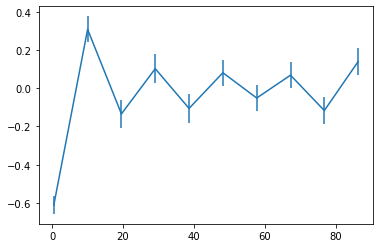

In [11]:
plt.errorbar(time, exp_mean, exp_std)
plt.show()